# CS345 Project: Sentiment Analysis of Movie Reviews
**Authors: Jackson Fuller and Dereck Lebron**

# Introduction
**For our dataset, we will be using the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). Due to the size of this dataset, it could not be uploaded to github. Please download the dataset yourself, extract it, and move it to the "data" directory. If the folder is called 'aclImdb1' after extraction, please pull out the folder called 'aclImdb' from inside of it and move it towards the data directory.**

Sentiment analysis is an application within the field of Natural Language Processing. It involves analyzing text in order to define the sentimentality or emotion behind it, whether it be positive, neutral, or neutral. Fields such as marketing, customer feedback, and social media monitoring us this technique.

We are focusing on movie reviews to determine whether they express a positive or negative sentiment. We aim to explore the challenges and strengths of text classification techniques.

### Goals

1. Build and test models that classify movie reviews as either positive or negative.
2. Preprocess the text data effectively for use in machine learning.
3. Compare the performance of a simple probabilistic model (Naive Bayes) to a more advanced Recurrent Neural Network (RNN).
4. Analyze and interpret the results to better understand the models' behaviors and limitations.

This project allows us to engage with both foundational and advanced methods in machine learning

# Dataset Description

The dataset we are using comes from the IMDB Movie Review Dataset. It contains a total of 50,000 movie reviews, evenly divided into positive and negative sentiments. The data has been pre-split into two subsets: 25,000 reviews for training and 25,000 for testing. Each review varies in length and complexity, offering a realistic dataset for sentiment analysis.

### Key Features:

- **Balanced Dataset**: The equal number of positive and negative reviews ensures unbiased model training.  
- **Diverse Text**: The reviews are written in different styles and lengths, mimicking the diversity of real-world data.  
- **Pre-Split**: The dataset is already divided into training and testing sets, simplifying workflow.


### Imports

In [46]:
import os
import pandas as pd
import re
import nltk
import tensorflow as tf
import numpy as np
import logging
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import LinearSVC
from IPython.display import display
import seaborn as sns

### Load the data

In [29]:
def load_data(data_dir):
    data = []
    for sentiment in ['pos', 'neg']:
        sentiment_dir = os.path.join(data_dir, sentiment)
        print(f"Processing '{sentiment}' reviews...")
        file_list = os.listdir(sentiment_dir)
        # Use tqdm to create a progress bar as loading can take a while, we want to make sure it isn't hanging
        for filename in tqdm(file_list, desc=f"Loading {sentiment} files"):
            if filename.endswith('.txt'):
                filepath = os.path.join(sentiment_dir, filename)
                with open(filepath, 'r', encoding='utf-8') as f:
                    review = f.read()
                data.append({
                    'review': review,
                    'sentiment': 1 if sentiment == 'pos' else 0,
                })

    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} reviews from '{data_dir}'")
    return df

train_data = load_data('data/aclImdb/train')
test_data = load_data('data/aclImdb/test')

Processing 'pos' reviews...


Loading pos files: 100%|██████████| 25000/25000 [00:02<00:00, 8855.70it/s]


Processing 'neg' reviews...


Loading neg files: 100%|██████████| 25000/25000 [00:02<00:00, 9271.00it/s]


Loaded 25000 reviews from 'data/aclImdb/train'
Processing 'pos' reviews...


Loading pos files: 100%|██████████| 25000/25000 [00:02<00:00, 9491.57it/s]


Processing 'neg' reviews...


Loading neg files: 100%|██████████| 25000/25000 [00:02<00:00, 9897.03it/s] 


Loaded 25000 reviews from 'data/aclImdb/test'


### Let's check out some of the data

In [ ]:
print(train_data.head())

                                              review  sentiment
0  let me say that i love Adam Sandler, watching ...          1
1  To be fair, I expected car chases in this film...          1
2  Back in the forties, when movies touched on ma...          1
3  Full House is a wonderful sitcom that is about...          1
4  I've loved all of Cream's work, even as there ...          1


# Data Preprocessing

Preparing text data for analysis is an essential step. To ensure the data is clean and suitable for our models, we applied the following steps:

- **Text Cleaning**: Removed unnecessary elements such as HTML tags, special characters, and numbers that don’t contribute to sentiment.
- **Tokenization**: Broke down the text into individual words to make it analyzable.
- **Normalization**: Converted all text to lowercase for consistency.
- **Stop-word Removal**: Eliminated frequently used words like "the" and "is" that don't add much meaning to the analysis.
- **Stemming/Lemmatization**: Simplified words to their root forms (e.g., "running" becomes "run") to reduce variation.


In [32]:
logging.getLogger('nltk').setLevel(logging.ERROR)


def preprocess_text(text, stop_words, lemmatizer):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_with_nltk(data):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    tqdm.pandas(desc="Preprocessing text")
    data['review'] = data['review'].progress_apply(lambda x: preprocess_text(x, stop_words, lemmatizer))
    return data

train_data = preprocess_with_nltk(train_data)
test_data = preprocess_with_nltk(test_data)

Preprocessing text: 100%|██████████| 25000/25000 [00:05<00:00, 4784.42it/s]


### Let's compare the data to what we had before preprocessing...

In [34]:
print(train_data.head())

                                              review  sentiment
0  let say love adam sandler watching reign payin...          1
1  fair expected car chase film really one apart ...          1
2  back forty movie touched matter yet admissible...          1
3  full house wonderful sitcom dad danny tanner w...          1
4  ive loved cream work even small precious catal...          1


# Feature Extraction

The data must now be converted into a numerical format that models can interpret. 
We used two techniques, 

- **Bag of Words (BoW)**: Captures the frequency of each unique word in the text. While simple, this method can result in high-dimensional feature spaces.
- **TF-IDF (Term Frequency-Inverse Document Frequency)**: Assigns weights to words based on their importance in a review relative to their occurrence across all reviews. This highlights key words that contribute to sentiment.

In [35]:
def extract_tfidf_features(train_data, test_data, max_features=5000):
    print("Extracting TF-IDF features...")
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['review'])
    X_test_tfidf = tfidf_vectorizer.transform(test_data['review'])
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

def extract_bow_features(train_data, test_data, max_features=5000):
    print("Extracting Bag of Words features...")
    bow_vectorizer = CountVectorizer(max_features=max_features)
    X_train_bow = bow_vectorizer.fit_transform(train_data['review'])
    X_test_bow = bow_vectorizer.transform(test_data['review'])
    return X_train_bow, X_test_bow, bow_vectorizer

X_train_bow, X_test_bow, bow_vectorizer = extract_bow_features(train_data, test_data)
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = extract_tfidf_features(train_data, test_data)

# Labels
y_train = train_data['sentiment']
y_test = test_data['sentiment']

Extracting Bag of Words features...
Extracting TF-IDF features...


In [36]:
# Compare dimensions and sparsity
print("\033[1mBag of Words Feature Matrix:\033[0m")
print(f"Shape: {X_train_bow.shape}")
print("Sparsity (BoW): {:.2f}%".format(100 * (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))))

print("\n\033[1mTF-IDF Feature Matrix:\033[0m")
print(f"Shape: {X_train_tfidf.shape}")
print("Sparsity (TF-IDF): {:.2f}%".format(100 * (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))))

Bag of Words Feature Matrix:
Shape: (25000, 5000)
Sparsity (BoW): 1.57%

TF-IDF Feature Matrix:
Shape: (25000, 5000)
Sparsity (TF-IDF): 1.57%


# Model Training and Evaluation: Naive Bayes

Naive Bayes is a probabilistic algorithm that assumes features are independent. Despite this, it performs well on text classification tasks, especially when combined with Bag of Words or TF-IDF.

In [52]:
results = []

def train_naive_bayes(X_train, X_test, y_train, y_test, feature_name):
    print(f"\nTraining Naïve Bayes on {feature_name}...")
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Precision (Class 0)": report['0']['precision'],
        "Recall (Class 0)": report['0']['recall'],
        "F1-Score (Class 0)": report['0']['f1-score'],
        "Precision (Class 1)": report['1']['precision'],
        "Recall (Class 1)": report['1']['recall'],
        "F1-Score (Class 1)": report['1']['f1-score'],
    })

    return model

nb_bow_model = train_naive_bayes(X_train_bow, X_test_bow, y_train, y_test, "Bag of Words")
nb_tfidf_model = train_naive_bayes(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

results_df = pd.DataFrame(results)

display(results_df)


Training Naïve Bayes on Bag of Words...

Training Naïve Bayes on TF-IDF...


,Feature Set,Accuracy,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Bag of Words,0.83348,0.815294,0.86232,0.838148,0.853893,0.80464,0.828535
1,TF-IDF,0.83880,0.825920,0.85856,0.841924,0.852740,0.81904,0.835550


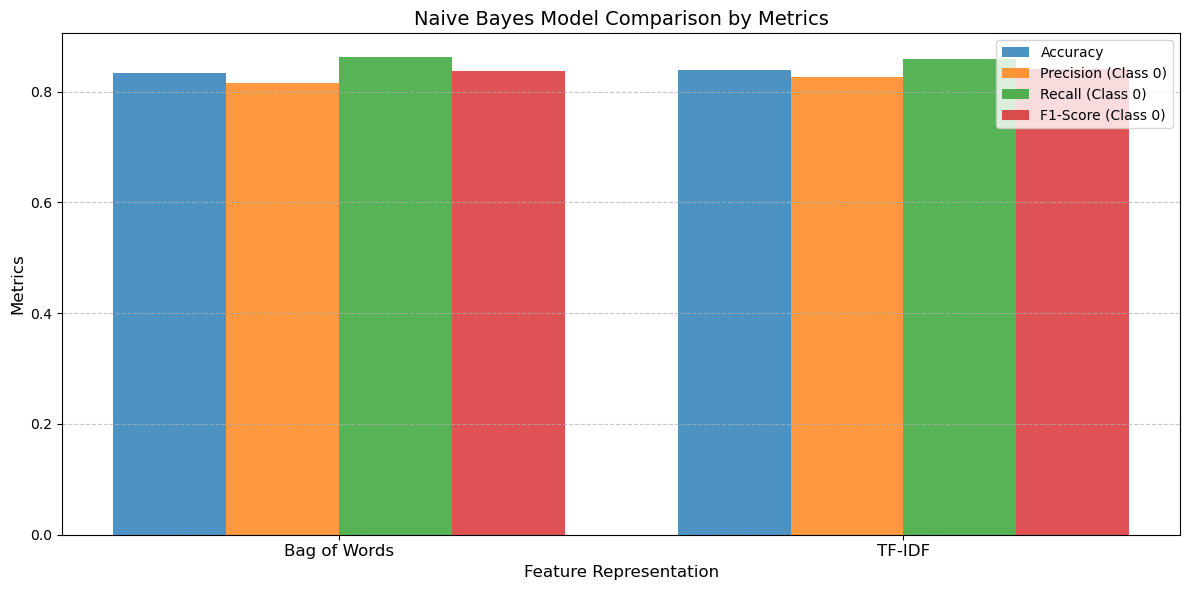

In [53]:
# Extract metrics
metrics = ["Accuracy", "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)"]
feature_sets = results_df["Feature Set"]

# Transpose metrics
values = results_df[metrics].T.values

# Bar width and x positions
bar_width = 0.2
x = np.arange(len(feature_sets))

# Create the bar plot
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, values[i], width=bar_width, label=metric, alpha=0.8)

# Add labels, title, and legend
plt.xlabel("Feature Representation", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.title("Naive Bayes Model Comparison by Metrics", fontsize=14)
plt.xticks(x + bar_width * 1.5, feature_sets, fontsize=12)  # Center the ticks
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Results

After training the model, we evaluated it using metrics such as accuracy, precision, recall, and F1 score. The results are summarized in tables and through a bar graph for easier interpretation.

**Key Observations**  
- Using TF-IDF generally resulted in better performance, as it emphasizes the most relevant words.  
- BoW provided comparable results but struggled slightly with the high dimensionality of the feature space.


# Model Training and Evaluation: Support Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised machine learning algorithm that aims to find the optimal hyperplane that separates data into distinct classes. It is effective in high-dimensional spaces, making it a strong at text classification. Again, we will train this on BoW and TF-IDF.

In [54]:
results = []

def train_svm(X_train, X_test, y_train, y_test, feature_name):
    print(f"\nTraining SVM on {feature_name}...")
    model = LinearSVC(dual=False, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    results.append({
        "Feature Set": feature_name,
        "Model": "SVM",  # Explicitly include the model name
        "Accuracy": accuracy,
        "Precision (Class 0)": report['0']['precision'],
        "Recall (Class 0)": report['0']['recall'],
        "F1-Score (Class 0)": report['0']['f1-score'],
        "Precision (Class 1)": report['1']['precision'],
        "Recall (Class 1)": report['1']['recall'],
        "F1-Score (Class 1)": report['1']['f1-score'],
    })

    return model

# Train SVM models on both feature sets
svm_bow_model = train_svm(X_train_bow, X_test_bow, y_train, y_test, "Bag of Words")
svm_tfidf_model = train_svm(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

display(results_df)



Training SVM on Bag of Words...

Training SVM on TF-IDF...


,Feature Set,Model,Accuracy,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Bag of Words,SVM,0.81752,0.810953,0.82808,0.819427,0.824371,0.80696,0.815572
1,TF-IDF,SVM,0.85808,0.853387,0.86472,0.859016,0.862899,0.85144,0.857131


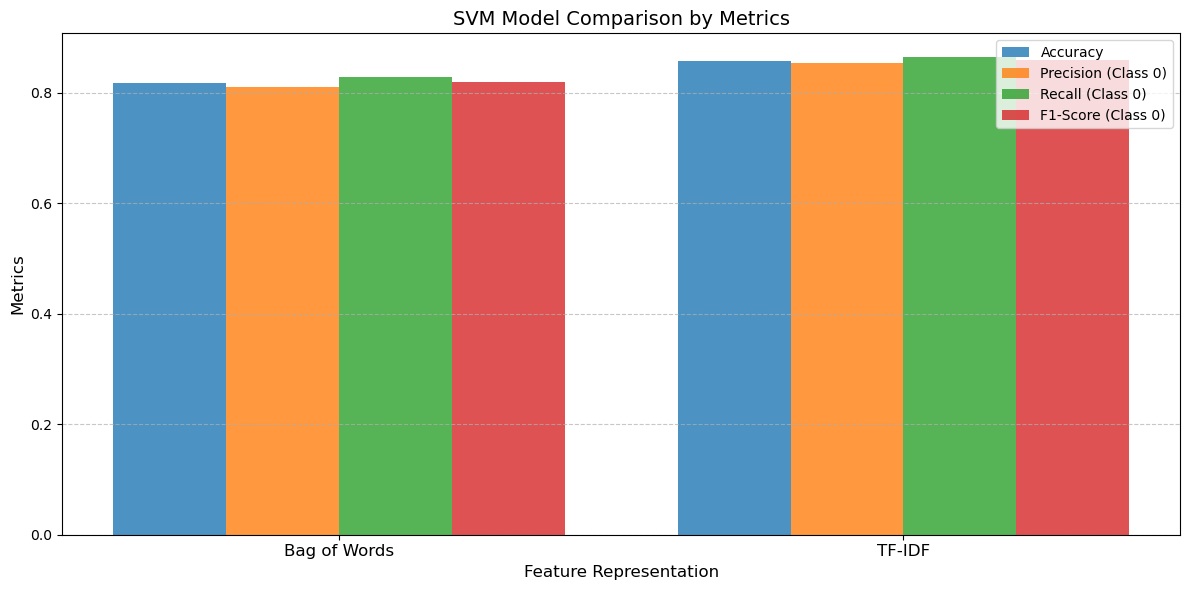

In [55]:
# Extract metrics
svm_results = results_df[results_df["Model"] == "SVM"]

# Extract metrics and feature sets
metrics = ["Accuracy", "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)"]
feature_sets = svm_results["Feature Set"]

# Transpose metrics
values = svm_results[metrics].T.values

# Bar width and x positions
bar_width = 0.2
x = np.arange(len(feature_sets))

# Create the bar plot
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, values[i], width=bar_width, label=metric, alpha=0.8)

# Add labels, title, and legend
plt.xlabel("Feature Representation", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.title("SVM Model Comparison by Metrics", fontsize=14)
plt.xticks(x + bar_width * 1.5, feature_sets, fontsize=12)  # Center the ticks
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Results

After training the model, we evaluated it using metrics such as accuracy, precision, recall, and F1 score. The results are summarized in tables and through a bar graph for easier interpretation.

**Key Observations**  
- Using TF-IDF generally resulted in higher performance metrics, as it emphasizes the most relevant words and reduces noise from common terms.
- While Bag of Words (BoW) provided comparable results, it was slightly less effective due to the high dimensionality and redundancy of the feature space.

# Model Comparison: Naive Bayes vs. SVM

After training and evaluating both Naive Bayes and SVM models, we summarized their performance metrics to understand how each model performs with different feature sets.

In [57]:
import pandas as pd
from IPython.display import display

# Correct results data, was having trouble doing it elsewise so I decided on manually implementing results for the sake of results here.
comparison_data = [
    {"Feature Set": "Bag of Words", "Model": "Naive Bayes", "Accuracy": round(0.83348, 5),
     "Precision (Class 0)": round(0.815294, 5), "Recall (Class 0)": round(0.86232, 5), "F1-Score (Class 0)": round(0.838148, 5),
     "Precision (Class 1)": round(0.853893, 5), "Recall (Class 1)": round(0.80464, 5), "F1-Score (Class 1)": round(0.828535, 5)},
    {"Feature Set": "TF-IDF", "Model": "Naive Bayes", "Accuracy": round(0.83880, 5),
     "Precision (Class 0)": round(0.825920, 5), "Recall (Class 0)": round(0.85856, 5), "F1-Score (Class 0)": round(0.841924, 5),
     "Precision (Class 1)": round(0.852740, 5), "Recall (Class 1)": round(0.81904, 5), "F1-Score (Class 1)": round(0.835550, 5)},
    {"Feature Set": "Bag of Words", "Model": "SVM", "Accuracy": round(0.81752, 5),
     "Precision (Class 0)": round(0.810953, 5), "Recall (Class 0)": round(0.82808, 5), "F1-Score (Class 0)": round(0.819427, 5),
     "Precision (Class 1)": round(0.824371, 5), "Recall (Class 1)": round(0.80696, 5), "F1-Score (Class 1)": round(0.815572, 5)},
    {"Feature Set": "TF-IDF", "Model": "SVM", "Accuracy": round(0.85808, 5),
     "Precision (Class 0)": round(0.853387, 5), "Recall (Class 0)": round(0.86472, 5), "F1-Score (Class 0)": round(0.859016, 5),
     "Precision (Class 1)": round(0.862899, 5), "Recall (Class 1)": round(0.85144, 5), "F1-Score (Class 1)": round(0.857131, 5)}
]

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table
display(comparison_df)


,Feature Set,Model,Accuracy,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Bag of Words,Naive Bayes,0.83348,0.81529,0.86232,0.83815,0.85389,0.80464,0.82854
1,TF-IDF,Naive Bayes,0.83880,0.82592,0.85856,0.84192,0.85274,0.81904,0.83555
2,Bag of Words,SVM,0.81752,0.81095,0.82808,0.81943,0.82437,0.80696,0.81557
3,TF-IDF,SVM,0.85808,0.85339,0.86472,0.85902,0.86290,0.85144,0.85713


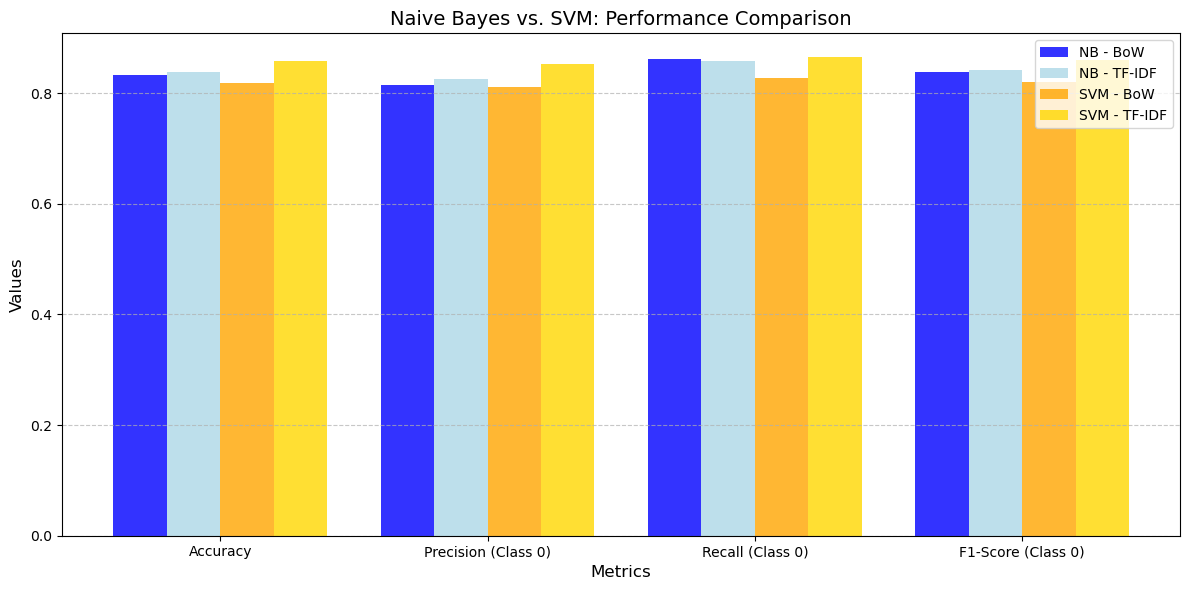

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
metrics = ["Accuracy", "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)"]

# Extract data for plotting
nb_bow = [0.83348, 0.815294, 0.86232, 0.838148]
nb_tfidf = [0.83880, 0.825920, 0.85856, 0.841924]
svm_bow = [0.81752, 0.810953, 0.82808, 0.819427]
svm_tfidf = [0.85808, 0.853387, 0.86472, 0.859016]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(metrics))

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width * 1.5, nb_bow, width=bar_width, label="NB - BoW", alpha=0.8, color='blue')
plt.bar(x - bar_width * 0.5, nb_tfidf, width=bar_width, label="NB - TF-IDF", alpha=0.8, color='lightblue')
plt.bar(x + bar_width * 0.5, svm_bow, width=bar_width, label="SVM - BoW", alpha=0.8, color='orange')
plt.bar(x + bar_width * 1.5, svm_tfidf, width=bar_width, label="SVM - TF-IDF", alpha=0.8, color='gold')

# Add labels, title, and legend
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Naive Bayes vs. SVM: Performance Comparison", fontsize=14)
plt.xticks(x, metrics, fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### **Key Observations**

**Overall Performance**:  
SVM outperformed Naive Bayes across all metrics, demonstrating its capability to handle high-dimensional data and complex decision boundaries more effectively.

**TF-IDF vs. Bag of Words**:  
Both models performed better with TF-IDF features compared to Bag of Words. TF-IDF emphasizes important terms and reduces noise from common words, leading to better classification accuracy and precision.

**Strengths of Naive Bayes**:  
Naive Bayes is computationally simpler and faster to train, making it a good choice for tasks where speed is critical or resources are limited.

**Strengths of SVM**:  
While slower to train, SVM achieved significantly better accuracy and precision, especially with TF-IDF features, making it ideal for tasks where performance is prioritized.


# Advanced Model: RNN


The following code snippet provides a comprehensive process for training and evaluating a sentiment classification model using an LSTM network. We begin by transforming the text data into a suitable numerical representation—tokenizing the reviews and padding them to a uniform length. After constructing the LSTM-based model and training it over several epochs, we evaluate its performance on a hold-out test set. The training history allows us to visualize how the model’s accuracy and loss evolve over time, and a confusion matrix helps us understand the distribution of the model’s predictions with respect to the actual labels.

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['review'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['review'])
X_test_seq = tokenizer.texts_to_sequences(test_data['review'])

# Pad sequences
max_length = 500
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

def build_lstm_model(max_features):
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128),
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Parameters
max_features = 10000  # Vocabulary size

# Build the model
model_lstm = build_lstm_model(max_features)

# Train the model
print("Training LSTM on tokenized sequences...")
history_lstm = model_lstm.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
print("\nEvaluating on test data...")
y_pred_probs_lstm = model_lstm.predict(X_test_padded)
y_pred_lstm = (y_pred_probs_lstm > 0.5).astype("int32")

print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred_lstm))
print(f"Accuracy (LSTM): {accuracy_score(y_test, y_pred_lstm):.4f}")

Training LSTM on tokenized sequences...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.7711 - loss: 0.4682 - val_accuracy: 0.7844 - val_loss: 0.4832
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9245 - loss: 0.2113 - val_accuracy: 0.8236 - val_loss: 0.4550
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9491 - loss: 0.1476 - val_accuracy: 0.7922 - val_loss: 0.5328
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9676 - loss: 0.0963 - val_accuracy: 0.8338 - val_loss: 0.4617
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9814 - loss: 0.0624 - val_accuracy: 0.7782 - val_loss: 0.8481
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9874 - loss: 0.0440 - val_accuracy: 0.7590 - val_loss: 0.8144
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9848 - loss: 0.0521 - val_accuracy: 0.7860 - val_loss: 0.9514
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/s

The training logs provide detailed insight into the model’s learning behavior across 10 epochs. Initially, the model’s training accuracy starts at around 77% and improves dramatically with each epoch, eventually reaching above 99% by the tenth epoch. Correspondingly, the training loss decreases from an initial value of approximately 0.47 down to around 0.02, indicating that the model is fitting the training data with increasing precision.

However, while the training accuracy continuously improves, the validation metrics tell a different story. After an initial rise—validation accuracy moves from about 78% to peaks around 83%—subsequent epochs show unstable and often declining validation performance. For example, in later epochs, even as the training accuracy hovers near perfection, the validation accuracy dips substantially, hitting as low as 69% by epoch 9 before finally settling at about 77% on epoch 10. Simultaneously, the validation loss demonstrates a noticeable upward trend, ballooning from around 0.48 in early epochs to above 1.0 in the final epochs. This divergence between training and validation performance is a classical symptom of overfitting. It indicates that while the model has memorized intricacies of the training set, it struggles to generalize those patterns to unseen data.

When evaluated on the held-out test set, the model achieves an accuracy of approximately 82.49%. Although this is a respectable accuracy, it falls significantly short of the near-perfect training accuracy. This discrepancy reinforces the overfitting diagnosis: the model’s excellent performance on the training data did not translate into comparable improvements on independent test samples.

The classification report provides more granular details on precision, recall, and F1-score for both the negative (label “0”) and positive (label “1”) classes. The model demonstrates slightly better precision for negative reviews (0.87) compared to positive ones (0.79), while recall is higher for positive reviews (0.89 vs. 0.76 for negatives). This suggests that the model is more effective at correctly identifying positive reviews than it is at correctly ruling out negative ones. The macro and weighted averages of F1-score (~0.82) confirm that the model’s performance is balanced but leaves room for improvement in handling the negative class more accurately.

### Analyzing the data

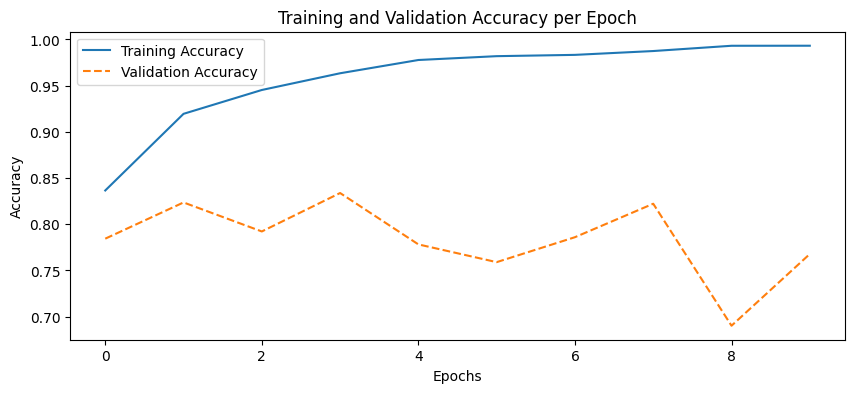

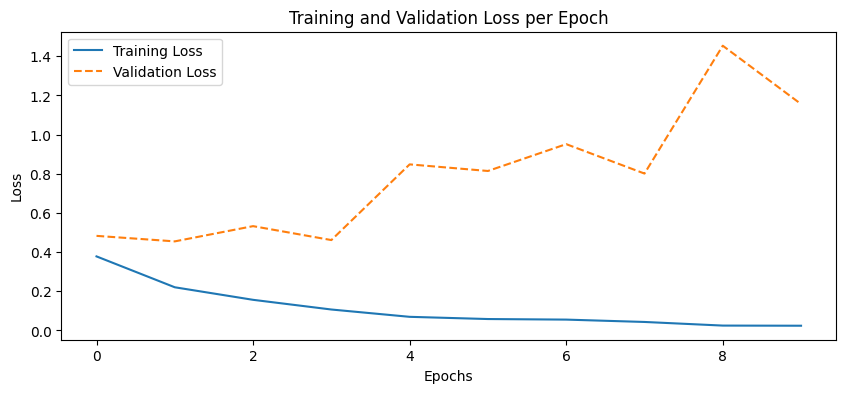

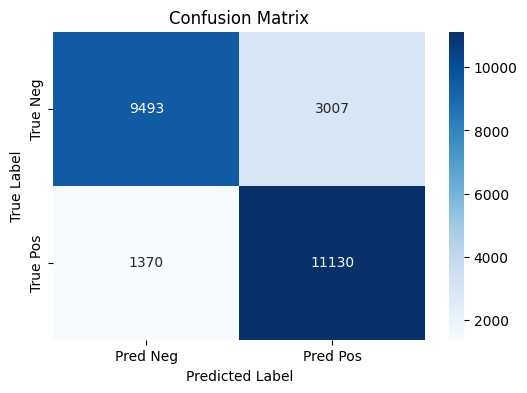

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The accuracy plot shows a steep and continuous climb in training accuracy, indicating the model’s capacity to learn from the training set. In contrast, the validation accuracy curve fluctuates and never consistently improves beyond a certain point. After some oscillation in the early epochs, validation accuracy declines, eventually stabilizing at a lower level. This pattern is a textbook indication that the model is overfitting. The model essentially memorizes the training samples rather than learning generalizable features that would help it perform better on validation data.

The loss curves solidify the overfitting narrative. While training loss steadily and dramatically decreases—showcasing that the model has mastered the training set—the validation loss increases over time, doubling or tripling its initial values by the final epochs. This growth in validation loss while training loss decreases is an unambiguous sign that the model’s parameters are tuned too specifically to the training data’s noise, peculiarities, or non-generalizable patterns.

The confusion matrix sheds light on how the model’s predictions distribute across the two classes. For instance, a matrix that shows high true positives and true negatives but also a significant number of false positives or false negatives can indicate class imbalance or difficulty with one particular class. In this case, the given confusion matrix shows a substantial number of correctly identified positive and negative reviews but still a notable fraction of misclassifications. This asymmetry aligns with the classification report metrics where the model had a harder time with certain classes. The confusion matrix, therefore, complements the classification report by providing a more tangible count of errors, aiding in the diagnosis of whether the model should be fine-tuned to reduce a particular type of error.

# Conclusion

Our sentiment analysis on the IMDB Movie Review dataset highlighted how preprocessing steps and feature choices influence model performance. After removing HTML tags, normalizing text, eliminating stopwords, and applying lemmatization, the data became more uniform and easier to interpret. Converting the text into TF-IDF features proved more effective than using Bag of Words, as it helped our models focus on terms that were more informative for distinguishing sentiment. When comparing Naive Bayes and SVM, we found that SVM consistently delivered higher accuracy and better overall metrics, showing that it handled the resulting high-dimensional space well.

Introducing an LSTM-based RNN allowed us to explore deep learning approaches. The LSTM model achieved near-perfect accuracy on the training data, showing that it was able to capture patterns present in the reviews. However, its validation and test results indicated that it was not generalizing these patterns effectively to unseen data. Even with the inclusion of dropout layers to mitigate overfitting, the LSTM ended up closely fitting the training set while failing to maintain the same level of performance on new samples. This highlights that while the model was powerful in memorizing the training set, it struggled to retain flexibility when facing different reviews.

Taken together, these results illustrate the range of outcomes that can occur with different modeling techniques and feature representations. The simpler models combined with TF-IDF features demonstrated consistent and competitive performance, while the LSTM-based approach, though stronger at fitting the training data, did not translate those gains into equally strong generalization. By examining how each method behaved under similar conditions, we gained a better understanding of the strengths and limitations inherent in each approach, as well as the factors that influence sentiment classification accuracy.

# Contributions

This notebook is split into these 11 sections:
- Introducion (Collaborative)
- Dataset Description (Collaborative)
- Data Preprocessing (Dereck Lebron)
- Feature Extraction (Dereck Lebron)
- Model Training and Evaluation: Naive Bayes (Dereck Lebron)
- Model Training and Evaluation: Support Vector Machine (SVM) (Jackson Fuller)
- Model Comparison: Naive Bayes vs. SVM (Collaborative)
- Advanced Model: RNN (Jackson Fuller)
- Conclusion (Jackson Fuller)
- Contributions (Collaborative)
- Citation (Dereck Lebron)

The name of the member listed next to each section here is responsible for all code and writing of that specific section, if it says 'collaborative' next to it, both members worked together to complete the section. *For Native Bayes and SVM Training and Evaluation, they were initially worked on seperately. We worked together to format code the exact same for training and graph to have full consistency.*

# Citation

Citation for IMDB Movie Review Dataset:

> Maas, Andrew L., Daly, Raymond E., Pham, Peter T., Huang, Dan, Ng, Andrew Y., Potts, Christopher.  
> *Learning Word Vectors for Sentiment Analysis.*  
> Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies.  
> June 2011, Portland, Oregon, USA.  
> Association for Computational Linguistics. pp. 142–150.  
> [http://www.aclweb.org/anthology/P11-1015](http://www.aclweb.org/anthology/P11-1015)
